<a href="https://colab.research.google.com/github/virgolibra/CASA0018-Assessment/blob/main/casa0018_assessment_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CASA0018 Assessment
version 2 -- Update 23/Mar/2022

Minghao ZHANG

This is the notebook for the assessment of the course CASA0018: Deep Learning for Sensor Networks.
The Assessment aims to build an individual project, which implements machine learning locally on a device.

The topic is Rock-Paper-Scissors Recognition based on the camera. The three different gestures are identified in real time.

Convolutional Neural Network (CNN) is used.



## Import dependencies

This section is to import relevant dependencies

In [69]:
%tensorflow_version 2.x

In [70]:
import os
import zipfile
import random
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import math

from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from shutil import copyfile

## Load Tensorflow Dataset

The dataset [rock_paper_scissors](https://www.tensorflow.org/datasets/catalog/rock_paper_scissors) contains images of hands playing rock, paper and scissor game. 

The soruce is from [Tensorflow Datasets](https://www.tensorflow.org/datasets/catalog/overview)

Source code: `tfds.image_classification.RockPaperScissors`

**Load Tensorflow dataset - rock_paper_scissors**

In [71]:
DATASET_NAME = 'rock_paper_scissors'

# Load dataset
dataset, info = tfds.load(DATASET_NAME, as_supervised=True, with_info=True)

**Look into dataset info**

The datasets contains 2892 images with resolution 300*300 in RGB colour space and three different labels 

In [72]:
info

tfds.core.DatasetInfo(
    name='rock_paper_scissors',
    version=3.0.0,
    description='Images of hands playing rock, paper, scissor game.',
    homepage='http://laurencemoroney.com/rock-paper-scissors-dataset',
    features=FeaturesDict({
        'image': Image(shape=(300, 300, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=3),
    }),
    total_num_examples=2892,
    splits={
        'test': 372,
        'train': 2520,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {rps,
    author = "Laurence Moroney",
    title = "Rock, Paper, Scissors Dataset",
    month = "feb",
    year = "2019",
    url = "http://laurencemoroney.com/rock-paper-scissors-dataset"
    }""",
    redistribution_info=,
)

**Check dataset labels**

label -- rock, paper, scissors

In [73]:
# Check dataset labels
num_classes = info.features["label"].num_classes  # number of classes
get_class_name = info.features["label"].int2str      # class names

print(num_classes)        # 3
print(get_class_name(0)); # rock
print(get_class_name(1)); # paper
print(get_class_name(2)); # scissors


3
rock
paper
scissors


**Slice the dataset to three sets (Train, validation and test)**

Number of images:
+ Train set: 2142
+ Valid set: 372
+ Test set: 378

The ratio is about 75%, 12.5%, 12.5%


In [74]:
train_set_raw, valid_set_raw, test_set_raw = tfds.load(DATASET_NAME, 
                                           split=["train[:85%]", "train[85%:]", "test"],
                                           as_supervised=True)
TRAIN_SIZE = len(train_set_raw)
VALID_SIZE = len(valid_set_raw)
TEST_SIZE = len(test_set_raw)

print("Train set size: ", TRAIN_SIZE)   # Train set size:  2142
print("Valid set size: ", VALID_SIZE)   # Valid set size:  378
print("Test set size: ", TEST_SIZE)     # Test set size:  372

Train set size:  2142
Valid set size:  378
Test set size:  372


## Explore the Dataset

**Preview the dataset**

In [75]:
# define dataset preview
def preview_dataset(dataset):
  plt.figure(figsize=(12, 8))
  plot_index = 0
  for features in dataset.take(8):
    (image, label) = features
    plot_index += 1
    plt.subplot(2, 4, plot_index)
    # plt.axis('Off')
    label = get_class_name(label.numpy())
    plt.title('Label: %s' % label)
    plt.imshow(image.numpy())

**Preview the train set**

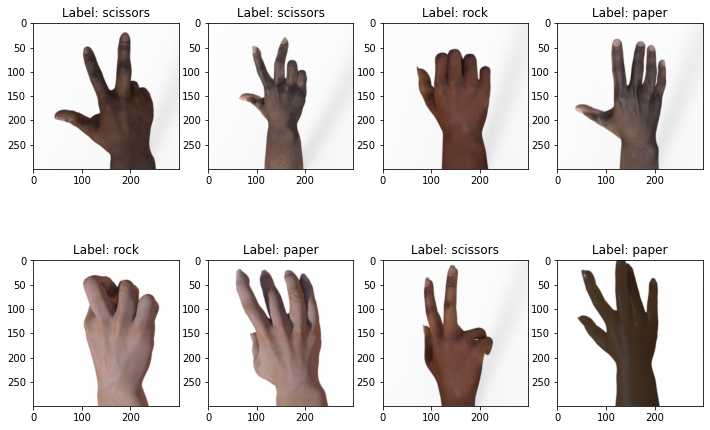

In [76]:
preview_dataset(train_set_raw)

**Preview the validation set**

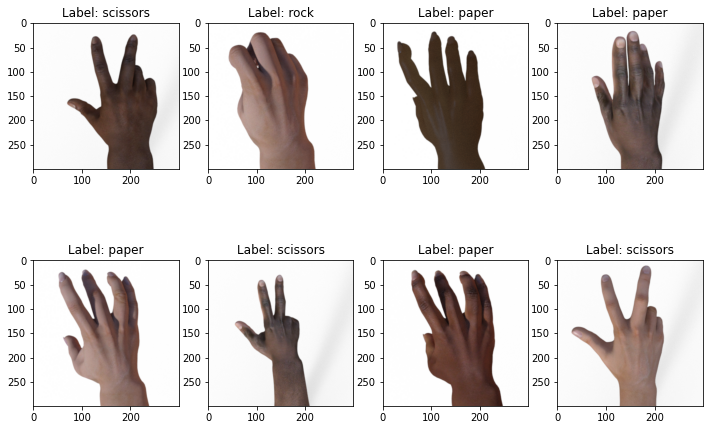

In [77]:
preview_dataset(valid_set_raw)

**Preview the test set**

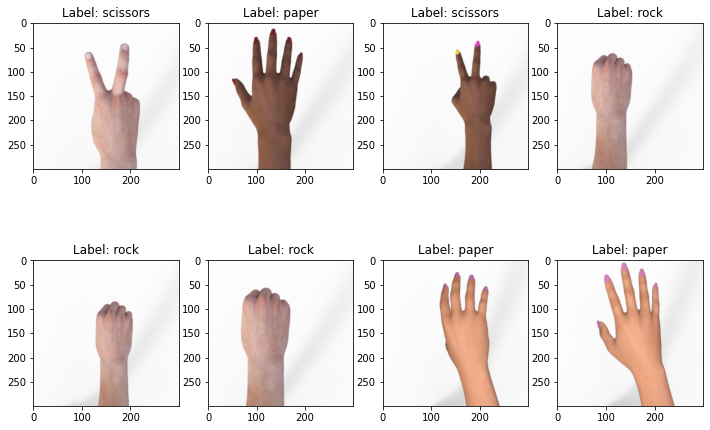

In [78]:
preview_dataset(test_set_raw)

**Explore the image format**

In [79]:
# Explore the image format
(image_sample, image_label) = list(train_set_raw.take(1))[0]
print('Label:', image_label.numpy(), '\n')
print('Image shape:', image_sample.numpy().shape, '\n')
print(image_sample.numpy())

Label: 2 

Image shape: (300, 300, 3) 

[[[254 254 254]
  [253 253 253]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [250 250 250]]

 [[254 254 254]
  [254 254 254]
  [253 253 253]
  ...
  [250 250 250]
  [251 251 251]
  [249 249 249]]

 [[254 254 254]
  [254 254 254]
  [254 254 254]
  ...
  [251 251 251]
  [250 250 250]
  [252 252 252]]

 ...

 [[252 252 252]
  [251 251 251]
  [252 252 252]
  ...
  [247 247 247]
  [249 249 249]
  [248 248 248]]

 [[253 253 253]
  [253 253 253]
  [251 251 251]
  ...
  [248 248 248]
  [248 248 248]
  [248 248 248]]

 [[252 252 252]
  [253 253 253]
  [252 252 252]
  ...
  [248 248 248]
  [247 247 247]
  [250 250 250]]]


## Pre-processing the dataset

Resize, transform, shuffle and batch images

#### Image Resize

**Set expected image size**

resize images from 300x300 to 150x150

In [80]:
IMG_SIZE_ORG = info.features['image'].shape[0]
IMG_SHAPE_ORG = info.features['image'].shape

IMG_SIZE_MOD = IMG_SIZE_ORG // 2
IMG_SHAPE_MOD = (IMG_SIZE_MOD, IMG_SIZE_MOD, IMG_SHAPE_ORG[2])

# Here we may switch between bigger or smaller image sized that we will train our model on.
IMG_SIZE = IMG_SIZE_MOD
IMG_SHAPE = IMG_SHAPE_MOD

print('Original image size:', IMG_SIZE_ORG)
print('Original image shape:', IMG_SHAPE_ORG)
print('Reduced image size:', IMG_SIZE_MOD)
print('Reduced image shape:', IMG_SHAPE_MOD)
print('Image size:', IMG_SIZE)
print('Image shape:', IMG_SHAPE)

Original image size: 300
Original image shape: (300, 300, 3)
Reduced image size: 150
Reduced image shape: (150, 150, 3)
Image size: 150
Image shape: (150, 150, 3)


**Reduce the image size**

In [81]:
def resize_image(img, label):
  img = tf.cast(img, tf.float32) # set color values to float
  img = img / 255.               # map color values to the range [0 1]
  img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
  return img, label

In [82]:
train_set_resize = train_set_raw.map(resize_image)
valid_set_resize = valid_set_raw.map(resize_image)
test_set_resize = test_set_raw.map(resize_image)


**Check the image format after the size reduced**

In [83]:
# Check the image format
(image_sample, image_label) = list(train_set_resize.take(1))[0]
print('Label:', image_label.numpy(), '\n')
print('Image shape:', image_sample.numpy().shape, '\n')
print(image_sample.numpy())

Label: 2 

Image shape: (150, 150, 3) 

[[[0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9843137  0.9843137  0.9843137 ]
  [0.98039216 0.98039216 0.98039216]]

 [[0.99607843 0.99607843 0.99607843]
  [0.995098   0.995098   0.995098  ]
  [0.995098   0.995098   0.995098  ]
  ...
  [0.98333335 0.98333335 0.98333335]
  [0.9813726  0.9813726  0.9813726 ]
  [0.98333335 0.98333335 0.98333335]]

 [[0.99607843 0.99607843 0.99607843]
  [0.9941176  0.9941176  0.9941176 ]
  [0.9941176  0.9941176  0.9941176 ]
  ...
  [0.9852941  0.9852941  0.9852941 ]
  [0.9852941  0.9852941  0.9852941 ]
  [0.9813726  0.9813726  0.9813726 ]]

 ...

 [[0.9862745  0.9862745  0.9862745 ]
  [0.98725486 0.98725486 0.98725486]
  [0.9882353  0.9882353  0.9882353 ]
  ...
  [0.9705882  0.9705882  0.9705882 ]
  [0.97352946 0.97352946 0.97352946]
  [0.9754902  0.9754902  0.9754902 ]]

 [[0.9882353  0.9882353  0.9882353

**Check the dataset preview**

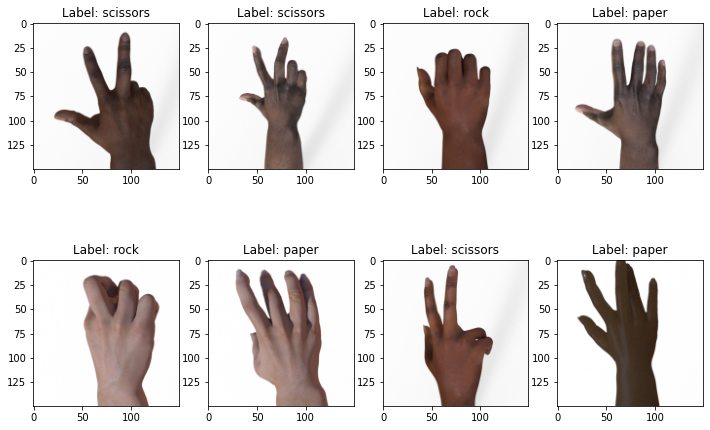

In [84]:
preview_dataset(train_set_resize)

#### Image Transform

**Define transformation**

The direction of various hands in the datasets are the same. To simulate the real situation, a series of image transform are defined and implemented, including colour, inversion, zoom, flip, rotate and grayscale.

Random function is applied to ensure randomness.



In [85]:
# colour
def random_img_colour(img: tf.Tensor) -> tf.Tensor:
  img = tf.image.random_brightness(img, 0.06)
  img = tf.image.random_hue(img, max_delta=0.06)
  img = tf.image.random_saturation(img, lower=0.6, upper=1.4)
  img = tf.image.random_contrast(img, lower=0.75, upper=1)
  img = tf.clip_by_value(img, clip_value_min=0, clip_value_max=1)
  return img

# rotation (0/90/180/270 degrees) 
def random_img_rotate(img: tf.Tensor) -> tf.Tensor:
  # Rotate 0, 90, 180, 270 degrees
  return tf.image.rot90(
    img,
    tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32)
  )

# flip up, down, left and right
def random_img_flip(img: tf.Tensor) -> tf.Tensor:
  img = tf.image.random_flip_left_right(img)
  img = tf.image.random_flip_up_down(img)
  return img

# zoom
def random_img_zoom(img: tf.Tensor, zoom_min=0.8, zoom_max=1.0) -> tf.Tensor:
  img_width, img_height, img_colours = img.shape
  crop_size = (img_width, img_height)

  # crop range 1% to 20%
  scales = list(np.arange(zoom_min, zoom_max, 0.01))
  boxes = np.zeros((len(scales), 4))

  for i, scale in enumerate(scales):
    x1 = y1 = 0.5 - (0.5 * scale)
    x2 = y2 = 0.5 + (0.5 * scale)
    boxes[i] = [x1, y1, x2, y2]

  def img_crop(img):
    # crop parameters
    crops = tf.image.crop_and_resize(
      [img],
      boxes=boxes,
      box_indices=np.zeros(len(scales)),
      crop_size=crop_size
    )
    # random crop
    return crops[tf.random.uniform(shape=[], minval=0, maxval=len(scales), dtype=tf.int32)]

  # set 50% propability to apply crop
  choice = tf.random.uniform(shape=[], minval=0., maxval=1., dtype=tf.float32)
  return tf.cond(choice < 0.5, lambda: img, lambda: img_crop(img))

# colour inversion
def random_img_inversion(img: tf.Tensor) -> tf.Tensor:
  random = tf.random.uniform(shape=[], minval=0, maxval=1)
  if random > 0.5:
    img = tf.math.multiply(img, -1)
    img = tf.math.add(img, 1)
  return img

# ----- GRAYSCALE ---------------------------------
def img_to_grayscale(img: tf.Tensor) -> tf.Tensor:
  img = tf.image.rgb_to_grayscale(img)
  return img
# ----- GRAYSCALE ---------------------------------

# apply random image transform
def image_transform(img,label):
  img = random_img_colour(img)
  img = random_img_inversion(img)
  img = random_img_zoom(img)
  img = random_img_flip(img)
  img = random_img_rotate(img)
# ----- GRAYSCALE ---------------------------------
  img = img_to_grayscale(img)
# ----- GRAYSCALE ---------------------------------  
  return img, label



**Implement transformation to train, validationa and test sets**

In [86]:
train_set_transformed = train_set_resize.map(image_transform)
valid_set_transformed = valid_set_resize.map(image_transform)
test_set_transformed = test_set_resize.map(image_transform)

In [87]:
# Check the image format
(image_sample, image_label) = list(train_set_transformed.take(1))[0]
print('Label:', image_label.numpy(), '\n')
print('Image shape:', image_sample.numpy().shape, '\n')
print(image_sample.numpy())

Label: 2 

Image shape: (150, 150, 1) 

[[[0.9102703 ]
  [0.9074738 ]
  [0.9102703 ]
  ...
  [0.9242525 ]
  [0.9223882 ]
  [0.927049  ]]

 [[0.9093381 ]
  [0.90840596]
  [0.90467733]
  ...
  [0.9223882 ]
  [0.92332035]
  [0.9242525 ]]

 [[0.9121346 ]
  [0.9102703 ]
  [0.9074738 ]
  ...
  [0.9242525 ]
  [0.92332035]
  [0.9223882 ]]

 ...

 [[0.9177275 ]
  [0.92145604]
  [0.92145604]
  ...
  [0.9298454 ]
  [0.9298454 ]
  [0.9317097 ]]

 [[0.9195918 ]
  [0.9177275 ]
  [0.9195918 ]
  ...
  [0.93077755]
  [0.93077755]
  [0.9317097 ]]

 [[0.9167953 ]
  [0.92052394]
  [0.92145604]
  ...
  [0.93077755]
  [0.93077755]
  [0.93077755]]]


**Check dataset after transformed**

In [88]:
# ----- GRAYSCALE ---------------------------------

# define dataset preview
def preview_dataset_grayscale(dataset):
  plt.figure(figsize=(12, 8))
  plot_index = 0
  for features in dataset.take(8):
    (image, label) = features
    plot_index += 1
    plt.subplot(2, 4, plot_index)
    label = get_class_name(label.numpy())
    plt.title('Label: %s' % label)
    plt.imshow(image.numpy()[:,:,0],cmap='gray')

# ----- GRAYSCALE ---------------------------------


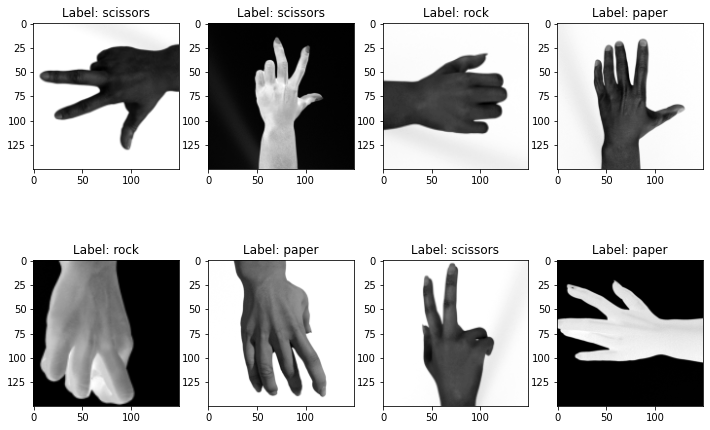

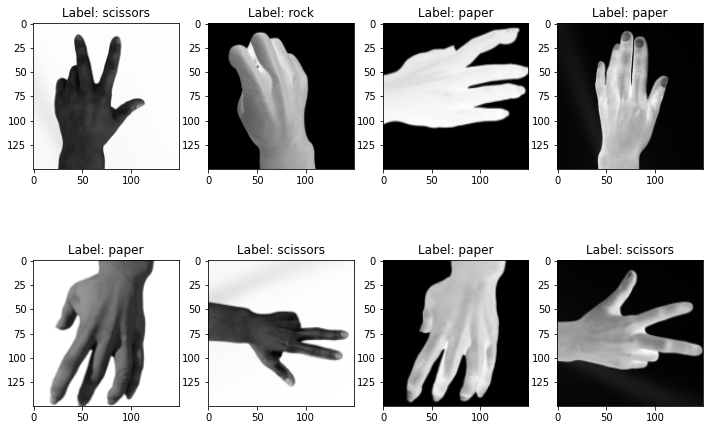

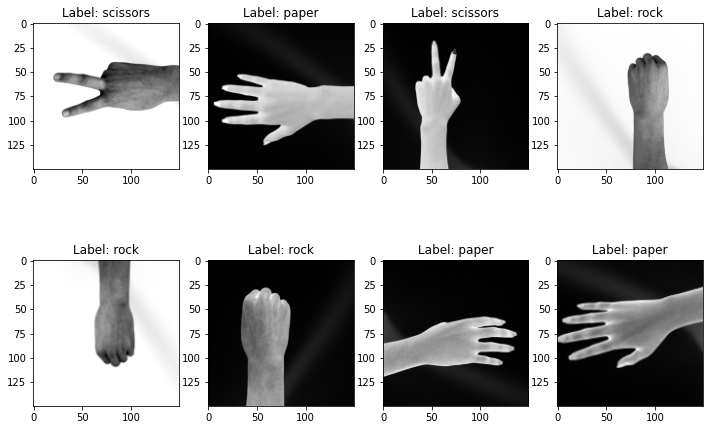

In [89]:
# preview_dataset(train_set_transformed)
# preview_dataset(valid_set_transformed)
# preview_dataset(test_set_transformed)

# ----- GRAYSCALE ---------------------------------
preview_dataset_grayscale(train_set_transformed)
preview_dataset_grayscale(valid_set_transformed)
preview_dataset_grayscale(test_set_transformed)

#### Shuffling and batching

Shuffling the data to ensure the model not to learn something from the order. The data batching is to split the set to speed up the train.

In [110]:
BATCH_SIZE = 32

train_set_shuffled = train_set_transformed.shuffle(buffer_size=TRAIN_SIZE)
train_set_shuffled = train_set_transformed.batch(batch_size=BATCH_SIZE)

# Prefetch will enable the input pipeline to asynchronously fetch batches while your model is training.
train_set_shuffled = train_set_shuffled.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE
)

valid_set_shuffled = valid_set_transformed.batch(BATCH_SIZE)
test_set_shuffled = test_set_transformed.batch(BATCH_SIZE)

print(train_set_shuffled)
print(valid_set_shuffled)
print(test_set_shuffled)

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


**Debug Batches**

Label batch shape: (32,) 

Image batch shape: (32, 150, 150, 1) 

Label batch: [2 2 0 1 0 1 2 1 2 2 1 1 2 1 1 1 1 1 1 1 1 0 0 0 0 1 1 2 2 2 0 0] 

First batch image: [[[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 ...

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]

 [[0.]
  [0.]
  [0.]
  ...
  [0.]
  [0.]
  [0.]]] 



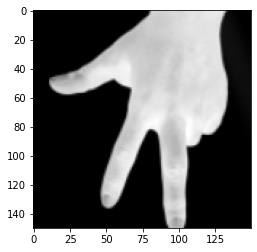

In [111]:
# Debugging batches
batches = tfds.as_numpy(train_set_shuffled)
for batch in batches:
  image_batch, label_batch = batch
  print('Label batch shape:', label_batch.shape, '\n')
  print('Image batch shape:', image_batch.shape, '\n')
  print('Label batch:', label_batch, '\n')
    
  for batch_item_index in range(len(image_batch)):
    print('First batch image:', image_batch[batch_item_index], '\n')
# ---------------------------------------- GRAYSCALE ---------------------------------       
    plt.imshow(image_batch[batch_item_index][:,:,0],cmap='gray')
# ----------------------------------------- GRAYSCALE ---------------------------------
    # plt.imshow(image_batch[batch_item_index])
    plt.show()
    break
  break

## Build Model

This section is to create and compile the model
Create the model with four convolution layers. The output unit is set to 3 as three gestures to be classfied. 

In [124]:

# ----- GRAYSCALE ---------------------------------
def create_model():
  model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu', input_shape = (150, 150, 1)), # shape 1 / for RGB using (150, 150, 3)
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation = 'relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation = 'relu'),
    tf.keras.layers.Dense(3, activation = 'softmax')
  ])

  adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  rmsprop_optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)

  model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
  )

  return model

model = create_model()

# ----- GRAYSCALE ---------------------------------

In [125]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 148, 148, 64)      640       
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 17, 17, 128)     

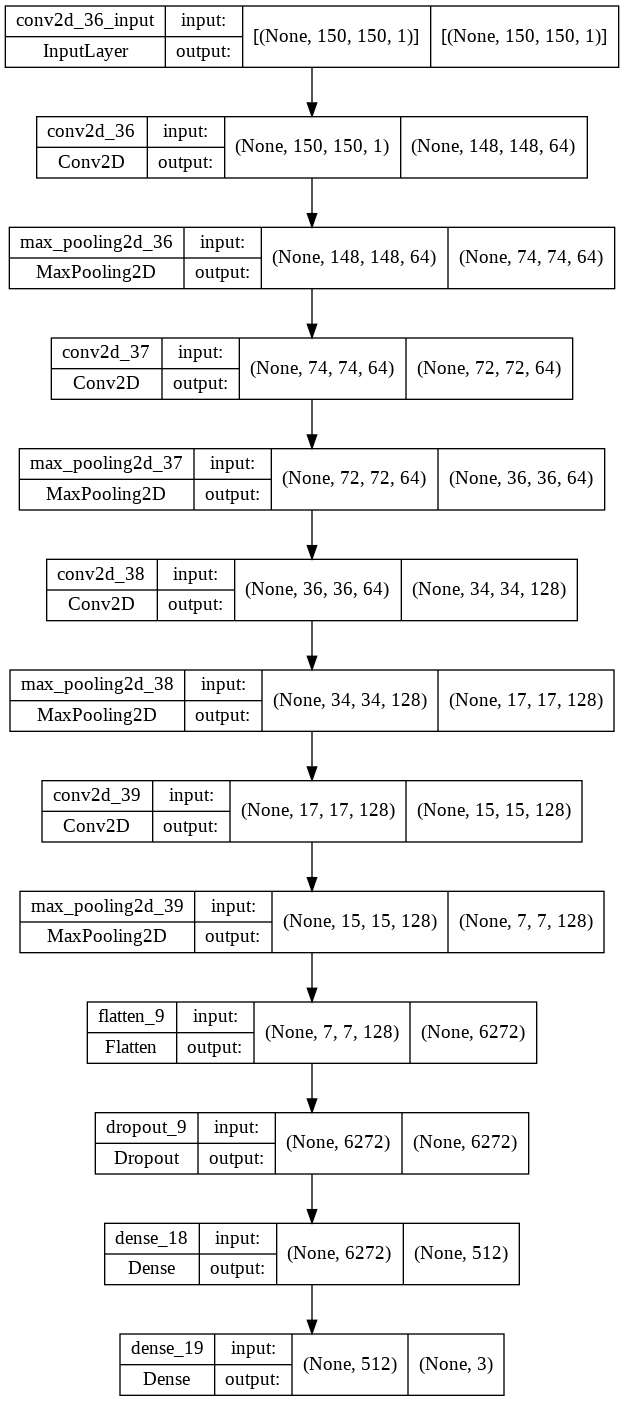

In [126]:
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

**Set steps and callbacks**

In [127]:
steps_per_epoch = TRAIN_SIZE // BATCH_SIZE
validation_steps = VALID_SIZE // BATCH_SIZE

print('steps_per_epoch:', steps_per_epoch)
print('validation_steps:', validation_steps)

!rm -rf tmp/checkpoints
!rm -rf logs

# Preparing callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

# os.makedirs('tmp/checkpoints', exist_ok=True)
# checkpoint_path = 'tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
# checkpoint_dir = os.path.dirname(checkpoint_path)
# model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
#     filepath = checkpoint_path,
#     verbose = 1
# )

# os.makedirs('tmp/checkpoints', exist_ok=True)
checkpoint_path = "training_1/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=5,
    monitor='val_accuracy'
    # monitor='val_loss'
)

steps_per_epoch: 66
validation_steps: 11


## Train Model

This section is to train the model with checkpoints stored 

In [128]:
training_history = model.fit(
    x=train_set_shuffled.repeat(),
    validation_data=valid_set_shuffled.repeat(),
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        cp_callback,
        # early_stopping_callback,
        # tensorboard_callback
    ],
    verbose=1
)

Epoch 1/10
66/66 [==============================] - ETA: 0s - loss: 0.9591 - accuracy: 0.5014
Epoch 1: saving model to training_1/cp.ckpt
66/66 [==============================] - 18s 271ms/step - loss: 0.9591 - accuracy: 0.5014 - val_loss: 0.8070 - val_accuracy: 0.6506
Epoch 2/10
66/66 [==============================] - ETA: 0s - loss: 0.4958 - accuracy: 0.8071
Epoch 2: saving model to training_1/cp.ckpt
66/66 [==============================] - 18s 270ms/step - loss: 0.4958 - accuracy: 0.8071 - val_loss: 0.4085 - val_accuracy: 0.8523
Epoch 3/10
66/66 [==============================] - ETA: 0s - loss: 0.3458 - accuracy: 0.8749
Epoch 3: saving model to training_1/cp.ckpt
66/66 [==============================] - 17s 268ms/step - loss: 0.3458 - accuracy: 0.8749 - val_loss: 0.3614 - val_accuracy: 0.8864
Epoch 4/10
66/66 [==============================] - ETA: 0s - loss: 0.2465 - accuracy: 0.9213
Epoch 4: saving model to training_1/cp.ckpt
66/66 [==============================] - 17s 263ms/s

In [129]:
os.listdir(checkpoint_dir)

['cp.ckpt.index', 'checkpoint', 'cp.ckpt.data-00000-of-00001']

**Plot training history**

In [130]:
def render_training_history(training_history):
    loss = training_history.history['loss']
    val_loss = training_history.history['val_loss']

    accuracy = training_history.history['accuracy']
    val_accuracy = training_history.history['val_accuracy']

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 2, 1)
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(loss, label='Training set')
    plt.plot(val_loss, label='Validation set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.subplot(1, 2, 2)
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(accuracy, label='Training set')
    plt.plot(val_accuracy, label='Validation set', linestyle='--')
    plt.legend()
    plt.grid(linestyle='--', linewidth=1, alpha=0.5)

    plt.show()

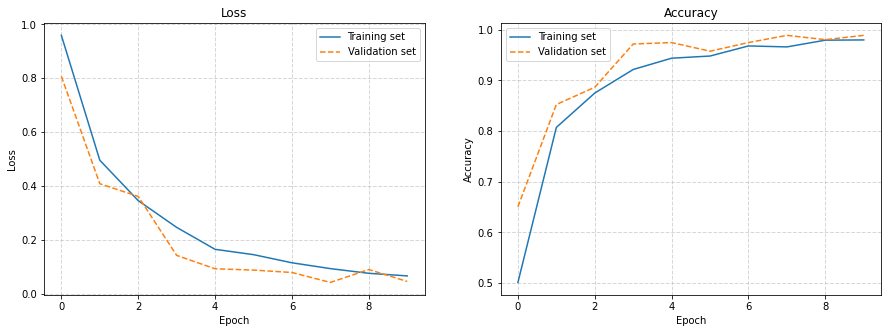

In [131]:
render_training_history(training_history)

## Test Model

Using pre-split test set to test the model (15%)

In [133]:
test_loss, test_accuracy = model.evaluate(test_set_shuffled, verbose=1)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

12/12 [==============================] - 3s 217ms/step - loss: 0.2928 - accuracy: 0.8710
Test loss:  0.29283520579338074
Test accuracy:  0.8709677457809448


## Save and Restore Model

This section is to test model save and restore



#### from a certain checkpoint

A new model is created and tested by the test set. The result shows that the accuracy of the untrained model is about 33%.

In [134]:
ckp_model = create_model()

ckp_loss, ckp_accuracy = ckp_model.evaluate(test_set_shuffled, verbose=1)

print('Test ckp_loss: ', ckp_loss)
print('Test ckp_accuracy: ', ckp_accuracy)


12/12 [==============================] - 4s 282ms/step - loss: 1.0986 - accuracy: 0.3226
Test ckp_loss:  1.0986371040344238
Test ckp_accuracy:  0.32258063554763794


Load the model from the latest checkpoint, which is generated by the callback function.

In [135]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest

ckp_model.load_weights(latest)

ckp_loss, ckp_accuracy = ckp_model.evaluate(test_set_shuffled, verbose=1)

print('Test ckp_loss: ', ckp_loss)
print('Test ckp_accuracy: ', ckp_accuracy)

12/12 [==============================] - 3s 204ms/step - loss: 0.3203 - accuracy: 0.8817
Test ckp_loss:  0.3202916085720062
Test ckp_accuracy:  0.8817204236984253


#### From final weights of trained model

Another new model is created and tested by the test set. The result shows that the accuracy of the untrained model is about 33%.

In [136]:
model.save_weights('./checkpoints/my_checkpoint')
sv_model = create_model()
sv_loss, sv_accuracy = sv_model.evaluate(test_set_shuffled, verbose=1)

print('Test ckp_loss: ', sv_loss)
print('Test ckp_accuracy: ', sv_accuracy)

12/12 [==============================] - 3s 201ms/step - loss: 1.0987 - accuracy: 0.3441
Test ckp_loss:  1.0987128019332886
Test ckp_accuracy:  0.34408602118492126


Load the model from the final checkpoint, which is generated by the save_weight() function to save the final weights of the trained model.

In [137]:
# Restore the weights
sv_model.load_weights('./checkpoints/my_checkpoint')

sv_loss, sv_accuracy = sv_model.evaluate(test_set_shuffled, verbose=1)

print('Test ckp_loss: ', sv_loss)
print('Test ckp_accuracy: ', sv_accuracy)

12/12 [==============================] - 3s 219ms/step - loss: 0.3359 - accuracy: 0.8575
Test ckp_loss:  0.33586978912353516
Test ckp_accuracy:  0.8575268983840942


#### From .h5 file
Save final trained model to .h5 file

In [105]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [106]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/train_model_v1.h5') 

Load model

In [ ]:
new_model = tf.keras.models.load_model('saved_model/train_model_v1.h5')

# Show the model architecture
new_model.summary()

Test Model

In [ ]:
test_loss, test_accuracy = new_model.evaluate(test_set_shuffled)

print('Test loss: ', test_loss)
print('Test accuracy: ', test_accuracy)

#### Save to Tensorflow Lite

In [ ]:
# Define paths to model files
import os
MODELS_DIR = 'models/'
if not os.path.exists(MODELS_DIR):
    os.mkdir(MODELS_DIR)
MODEL_TF = MODELS_DIR + 'model'
MODEL_NO_QUANT_TFLITE = MODELS_DIR + 'model_no_quant.tflite'
MODEL_TFLITE = MODELS_DIR + 'model.tflite'
MODEL_TFLITE_MICRO = MODELS_DIR + 'model.cc'

In [ ]:
# Save the model to disk
model.save(MODEL_TF)

Save tflite and quantization model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)  
tflite_model = converter.convert()  
with open('modelll.tflite', 'wb') as f:  
    f.write(tflite_model)  

converter = tf.lite.TFLiteConverter.from_keras_model(model)  
converter.optimizations = [tf.lite.Optimize.DEFAULT]  
tflite_quant_model = converter.convert()  
with open('quant_modellll.tflite', 'wb') as f:  
    f.write(tflite_quant_model) 

## Upload Model to Google Drive
Upload the model weights to google drive for the further implements on the Raspberry Pi

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
# !touch './checkpoints/my_checkpoint'
# !cp -r './checkpoints/my_checkpoint' /content/gdrive/ck1

## Upload Images to Test Performance

Images can be uploaded for recognition

Saving scissors105.jpg to scissors105 (1).jpg
scissors105.jpg
[[0. 0. 1.]]
scissors


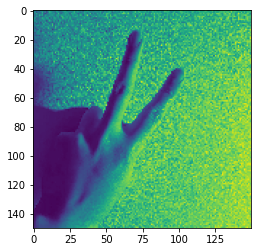

In [139]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():
  # predict images
  path = '/content/' + fn
  # img_source = image.load_img(path, target_size = (150, 150))
  img_source = image.load_img(path, color_mode = "grayscale", target_size = (150, 150))

  imgplot = plt.imshow(img_source)
  x = image.img_to_array(img_source)
  x = np.expand_dims(x, axis = 0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size = 10)

  print(fn)
  print(classes)
  if classes[0, 0] == 1:
    print('rock')
  elif classes[0, 1] == 1:
    print('paper')
  elif classes[0, 2] == 1:
    print('scissors')